<a href="https://colab.research.google.com/github/juan-a-vac/Automatizacion-del-proceso-de-calificacion-para-prestamos-/blob/main/Automatizaci%C3%B3n_de_la_calificaci%C3%B3n_para_un_pr%C3%A9stamo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Entendimiento del problema y definicion del objetivo
Contexto:

Una empresa desea automatizar el proceso de elegibilidad del préstamo (en tiempo real) en función de los detalles del cliente proporcionados al completar el formulario de solicitud en línea. 
Estos detalles son Género, Estado Civil, Educación, Número de Dependientes, Ingresos, Monto del Préstamo, Historial de Crédito entre otros. 
Para automatizar este proceso, han dado un problema para identificar los segmentos de clientes, aquellos son elegibles para el monto del préstamo para que puedan dirigirse específicamente a estos clientes. 

In [1]:
#Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report


import missingno as msno

# 2)Recoleccion de datos (Data Acquisition)

In [2]:
# Carga del dataset
loan_dataset = pd.read_csv('https://raw.githubusercontent.com/juan-a-vac/Automatizacion-del-proceso-de-calificacion-para-prestamos-/main/Prestamos.csv')

#3)Preprocesamiento y Analisis de datos (EDA) 

In [3]:
loan_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


- Loan_ID: es el ID de cada persona
- Dependents : es el numero de personas que dependen de la persona que quiere obtener el prestamos. Podria considerarse familiares a cargo.
- ApplicantIncome: es el ingreso de la persona en dolares.
- CoapplicantIncome: ingresos de su conyugue / pareja / similar.
- LoanAmount: monto del prestamos en dolares.
- Credit_History: 1 representa que sigue las pautas de la compania, 0 es lo contrario.
  

In [4]:
# medidas estadísticas
loan_dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
 loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


 Podemos observar que tenemos muchos datos del tipo Object

In [6]:
#Evaluamos la cantidad de datos duplicados que existen
duplicados = loan_dataset.duplicated() # Marca las filas que están duplicadas
hay_duplicados = any(duplicados) # Verifica si hay algún valor True en la columna

if hay_duplicados:
    print("Hay datos duplicados en el dataset")
else:
    print("No hay datos duplicados en el dataset")

No hay datos duplicados en el dataset


In [7]:
# Eliminamos la identificacion ya que no nos aporta informacion significativa para la ejecucion del modelo
loan_dataset=loan_dataset.drop("Loan_ID", axis = 1)

In [8]:
# Anteriormente encontramos variables de tipo object, vamos a estudiarlas mejor 
subdf = loan_dataset.select_dtypes(include=['object'])
subdf.head(5)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


In [9]:
for col in subdf.columns:
    print(f'Valores únicos en la columna {col}:')
    print(subdf[col].unique())

Valores únicos en la columna Gender:
['Male' 'Female' nan]
Valores únicos en la columna Married:
['No' 'Yes' nan]
Valores únicos en la columna Dependents:
['0' '1' '2' '3+' nan]
Valores únicos en la columna Education:
['Graduate' 'Not Graduate']
Valores únicos en la columna Self_Employed:
['No' 'Yes' nan]
Valores únicos en la columna Property_Area:
['Urban' 'Rural' 'Semiurban']
Valores únicos en la columna Loan_Status:
['Y' 'N']


Realizo cambios a 0 y 1 manualmente en los features Gender, Marriedm,  Education, Self_Employed y en Loan_Status. 

In [10]:
loan_dataset["Married"]=loan_dataset["Married"].map({"Yes":1,"No":0})
loan_dataset["Gender"]=loan_dataset["Gender"].map({"Male":1,"Female":0})
loan_dataset["Education"]=loan_dataset["Education"].map({"Graduate":1,"Not Graduate":0})
loan_dataset["Self_Employed"]=loan_dataset["Self_Employed"].map({"Yes":1,"No":0})
loan_dataset["Loan_Status"]=loan_dataset["Loan_Status"].map({"Y":1,"N":0})


In [11]:
#Los datos del tipo Object que nos quedan son los siguientes
subdf = loan_dataset.select_dtypes(include=['object'])
for col in subdf.columns:
    print(f'Valores únicos en la columna {col}:')
    print(loan_dataset[col].unique())

Valores únicos en la columna Dependents:
['0' '1' '2' '3+' nan]
Valores únicos en la columna Property_Area:
['Urban' 'Rural' 'Semiurban']


In [12]:
subdf = pd.get_dummies(subdf, columns=['Dependents', 'Property_Area'])
subdf.head(5)

,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,0,0,0,1
1,0,1,0,0,1,0,0
2,1,0,0,0,0,0,1
3,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1


In [13]:
loan_dataset = loan_dataset.drop(['Dependents', 'Property_Area'], axis=1)

In [14]:
# Concatenamos los dos datasets creados anteriormente, obteniendo un nuevo dataset pero ahora con la feature "Class" balanceada
loan_dataset = pd.concat([loan_dataset, subdf], axis=1)
loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   601 non-null    float64
 1   Married                  611 non-null    float64
 2   Education                614 non-null    int64  
 3   Self_Employed            582 non-null    float64
 4   ApplicantIncome          614 non-null    int64  
 5   CoapplicantIncome        614 non-null    float64
 6   LoanAmount               592 non-null    float64
 7   Loan_Amount_Term         600 non-null    float64
 8   Credit_History           564 non-null    float64
 9   Loan_Status              614 non-null    int64  
 10  Dependents_0             614 non-null    uint8  
 11  Dependents_1             614 non-null    uint8  
 12  Dependents_2             614 non-null    uint8  
 13  Dependents_3+            614 non-null    uint8  
 14  Property_Area_Rural      6

Observamos que el dataset posee datos nulos 

In [15]:
# número de valores faltantes en cada columna
loan_dataset.isnull().sum()

Gender                     13
Married                     3
Education                   0
Self_Employed              32
ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                 22
Loan_Amount_Term           14
Credit_History             50
Loan_Status                 0
Dependents_0                0
Dependents_1                0
Dependents_2                0
Dependents_3+               0
Property_Area_Rural         0
Property_Area_Semiurban     0
Property_Area_Urban         0
dtype: int64

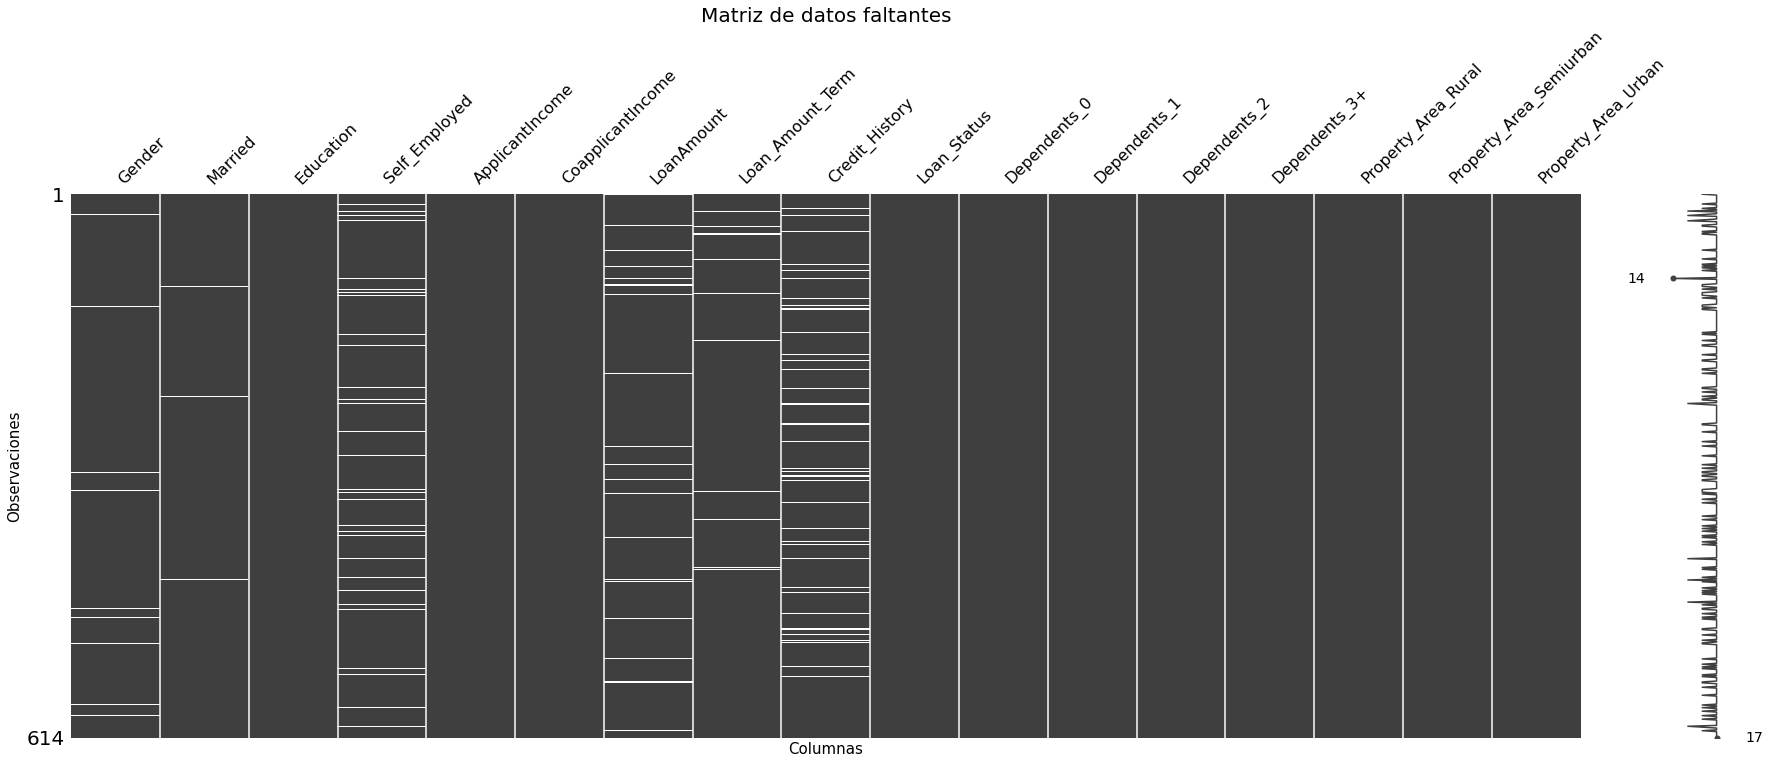

In [16]:
# Visualizar la matriz de valores faltantes
msno.matrix(loan_dataset, figsize=(30, 10), sparkline=True)

# Configurar el título y los ejes
plt.title('Matriz de datos faltantes',fontsize=20)
plt.xlabel('Columnas',fontsize=15)
plt.ylabel('Observaciones',fontsize=15)

# Mostrar la visualización
plt.show()

In [17]:
loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   601 non-null    float64
 1   Married                  611 non-null    float64
 2   Education                614 non-null    int64  
 3   Self_Employed            582 non-null    float64
 4   ApplicantIncome          614 non-null    int64  
 5   CoapplicantIncome        614 non-null    float64
 6   LoanAmount               592 non-null    float64
 7   Loan_Amount_Term         600 non-null    float64
 8   Credit_History           564 non-null    float64
 9   Loan_Status              614 non-null    int64  
 10  Dependents_0             614 non-null    uint8  
 11  Dependents_1             614 non-null    uint8  
 12  Dependents_2             614 non-null    uint8  
 13  Dependents_3+            614 non-null    uint8  
 14  Property_Area_Rural      6

In [18]:
# calcular la media de las columnas numéricas
mean_values = loan_dataset.mean()

# reemplazar los valores faltantes con la media
loan_dataset = loan_dataset.fillna(mean_values)
loan_dataset.isnull().sum()

Gender                     0
Married                    0
Education                  0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
Dependents_0               0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Property_Area_Rural        0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64

Data Visualization

<Axes: xlabel='Education', ylabel='count'>

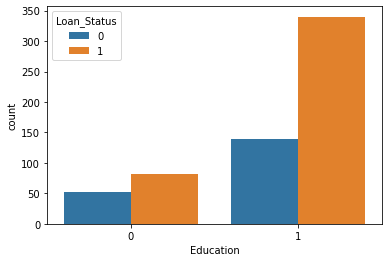

In [19]:
# educación y estado del préstamo
sns.countplot(x='Education',hue='Loan_Status',data=loan_dataset)

0 = no graduado

1 = graduado

En general el prestamos se les da en mayor proporcion a las personas graduadas.

<Axes: xlabel='Married', ylabel='count'>

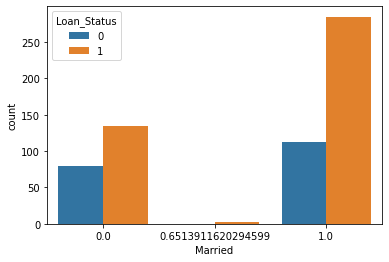

In [20]:
# estado civil y estado del préstamo
sns.countplot(x='Married',hue='Loan_Status',data=loan_dataset)

En este caso, en general a las personas casadas se les otorga mas prestamos

#5) Modelado

In [21]:
# separando los datos y la etiqueta
x = loan_dataset.drop(columns=['Loan_Status'],axis=1)
y = loan_dataset['Loan_Status']

###5.1)Modelo: Support Vector Machine Model

In [22]:
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=2)

In [23]:
classifier = svm.SVC(kernel='linear')

In [26]:
#entrenando el modelo de soporte Vector Macine
classifier.fit(x_train,y_train)

SVC(kernel='linear')

###5.1.1)Evaluacion del Modelo 1

In [27]:
y_pred = classifier.predict(x_test)

<Axes: >

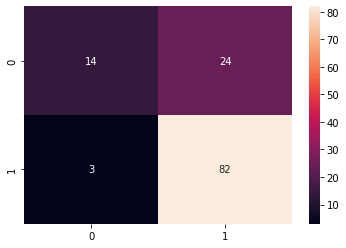

In [28]:
# Realizamos la evaluacion del modelo
cm = confusion_matrix( y_test, y_pred)
sns.heatmap(cm, annot=True)

In [29]:
Ev_modelo1 = classification_report(y_test,y_pred)
print(Ev_modelo1)

              precision    recall  f1-score   support

           0       0.82      0.37      0.51        38
           1       0.77      0.96      0.86        85

    accuracy                           0.78       123
   macro avg       0.80      0.67      0.68       123
weighted avg       0.79      0.78      0.75       123



Podemos observar que los resultados no son favorables, por lo que se implementará otro modelo de clasificacion

###5.2)Modelo 2: Regression logistica

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

###5.2.1)Evaluacion del Modelo 2


<Axes: >

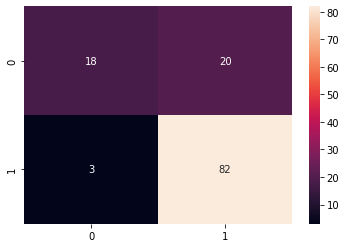

In [31]:
# Realizamos la evaluacion del modelo
cm = confusion_matrix( y_test, y_pred)
sns.heatmap(cm, annot=True)

In [32]:
Ev_modelo2 = classification_report(y_test,y_pred)
print(Ev_modelo2)

              precision    recall  f1-score   support

           0       0.86      0.47      0.61        38
           1       0.80      0.96      0.88        85

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123



Podemos observar que los resultados mejoran en relacion al modelo anterior

###5.3)Modelo 3: Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit (x_train, y_train)

RandomForestClassifier()

In [34]:
y_pred = model.predict(x_test)

###5.1.3)Evaluacion del Modelo 3

<Axes: >

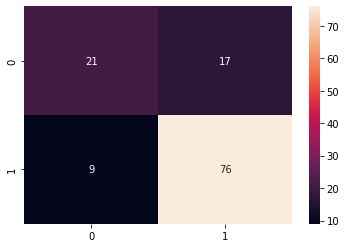

In [35]:
# Resultados en el Conjunto de Testing
cm = confusion_matrix( y_test, y_pred)
sns.heatmap(cm, annot=True)

In [36]:
Ev_modelo3=classification_report(y_test, y_pred)
print(Ev_modelo3)

              precision    recall  f1-score   support

           0       0.70      0.55      0.62        38
           1       0.82      0.89      0.85        85

    accuracy                           0.79       123
   macro avg       0.76      0.72      0.74       123
weighted avg       0.78      0.79      0.78       123



Comparacion de los modelos


In [37]:
print("Modelo 1 ------------------------------------------")
print(Ev_modelo1)
print("Modelo 2 ------------------------------------------")
print(Ev_modelo2)
print("Modelo 3 --------------------------------------------")
print(Ev_modelo3)

Modelo 1 ------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.37      0.51        38
           1       0.77      0.96      0.86        85

    accuracy                           0.78       123
   macro avg       0.80      0.67      0.68       123
weighted avg       0.79      0.78      0.75       123

Modelo 2 ------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.47      0.61        38
           1       0.80      0.96      0.88        85

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123

Modelo 3 --------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.55      0.62        38
           1       0.82      0.89      0.85        85

    accuracy            

Podemos observar que la eleccion del modelo estaria entre el Modelo 2 y el Modelo 3, los cuales poseen los mejores resultados